# Explaining Similarity with Morgan Fingerprints

This post comes out of a question I was asked at this week's CIC Spring School on Cheminformatics, where I did an introductory lecture on fingerprints.

# On to the work

## Start with the preliminaries

We start by doing a bunch of imports and defining some functions we'll use later.

*Note:* This is a Python3 notebook, so the code below may not work in Python2. It's also using code that is currently only present in github, but that will be in the next release

In [1]:
import numpy
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import rdBase
print(rdBase.rdkitVersion)

import time
print(time.asctime())
%pylab inline

2016.03.1.dev1
Thu Mar 10 19:01:19 2016
Populating the interactive namespace from numpy and matplotlib


In [2]:
#
# Functions for providing detailed descriptions of MFP bits 
#  inspired by some code from from Nadine Schneider 
#
def getSubstructSmi(mol,atomID,radius):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))
    else:
        atomsToUse = [atomID]
        env=None
    symbols = []
    for atom in mol.GetAtoms():
        deg = atom.GetDegree()
        isInRing = atom.IsInRing()
        nHs = atom.GetTotalNumHs()
        symbol = '['+atom.GetSmarts()
        if nHs: 
            symbol += 'H'
            if nHs>1:
                symbol += '%d'%nHs
        if isInRing:
            symbol += ';R'
        else:
            symbol += ';!R'
        symbol += ';D%d'%deg
        symbol += "]"
        symbols.append(symbol)
    smi = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,allHsExplicit=True, allBondsExplicit=True, rootedAtAtom=atomID)
    smi2 = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,atomSymbols=symbols, allBondsExplicit=True, rootedAtAtom=atomID)
    return smi,smi2

In [3]:
# Start by importing some code to allow the depiction to be used:
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D

# a function to make it a bit easier. This should probably move to somewhere in
# rdkit.Chem.Draw
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc
def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = rdMolDraw2D.PrepareMolForDrawing(mol,kekulize=kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

In [4]:
# do a depiction where the atom environment is highlighted normally and the central atom
# is highlighted in blue
def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse,highlightAtomColors={atomID:(0.3,0.3,1)})
def depictBit(bitId,mol,molSize=(450,200)):
    info={}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=2048,bitInfo=info)
    aid,rad = info[bitId][0]
    return getSubstructDepiction(mol,aid,rad,molSize=molSize)

## Basics: similarity between pyridine and benzene

In [5]:
bz = Chem.MolFromSmiles('c1ccccc1')
fp_bz = AllChem.GetMorganFingerprintAsBitVect(bz,radius=2,nBits=2048)
pyr = Chem.MolFromSmiles('c1ccccn1')
fp_pyr = AllChem.GetMorganFingerprintAsBitVect(pyr,radius=2,nBits=2048)
print("Similarity:",DataStructs.TanimotoSimilarity(fp_bz,fp_pyr))

Similarity: 0.3333333333333333


The question was: why is this value so low?

The obvious mathematical answer is to just look at the definition of Tanimoto similarity:

$Tani(fp_1,fp_2) = \frac{|fp_1 \cap fp_2|}{|fp_1|+|fp_2|-|fp_1 \cap fp_2|} = \frac{|fp_1 \cap fp_2|}{|fp_1 \cup fp_2|} $

In [6]:
print("intersection count:",(fp_bz&fp_pyr).GetNumOnBits())
print("union count:",(fp_bz|fp_pyr).GetNumOnBits())

intersection count: 3
union count: 9


But that doesn't really answer the question of "why", which boils down to the fact that the fingerprints don't have many bits in common relative to the number of bits set.

To understand why the two fingerprints have so few bits in common even though they look very similar to each other, we need to look at the bits themselves. This is most easily done using the bitInfo argument to the fingerprinter.

In [7]:
bi_bz = {}
fp_bz = AllChem.GetMorganFingerprintAsBitVect(bz,radius=2,nBits=2048,bitInfo=bi_bz)
bi_pyr = {}
fp_pyr = AllChem.GetMorganFingerprintAsBitVect(pyr,radius=2,nBits=2048,bitInfo=bi_pyr)

The bitInfo structures are dictionaries with bit IDs as keys and (atomId, radius) pairs as values:

In [8]:
bi_bz

{389: ((2, 2), (3, 2), (1, 2), (0, 2), (5, 2), (4, 2)),
 1088: ((1, 1), (2, 1), (3, 1), (4, 1), (0, 1), (5, 1)),
 1873: ((0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0))}

We will start by collecting information about the bits in lists.

Here's benzene:

In [9]:
info_bz = []
for bitId,atoms in bi_bz.items():
    exampleAtom,exampleRadius = atoms[0]
    description = getSubstructSmi(bz,exampleAtom,exampleRadius)
    info_bz.append((bitId,exampleRadius,description[0],description[1]))
print(info_bz)

[(1088, 1, '[cH](:[cH]):[cH]', '[cH;R;D2](:[cH;R;D2]):[cH;R;D2]'), (1873, 0, '[cH]', '[cH;R;D2]'), (389, 2, '[cH](:[cH]:[cH]):[cH]:[cH]', '[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]')]


And pyridine:

In [10]:
info_pyr = []
for bitId,atoms in bi_pyr.items():
    exampleAtom,exampleRadius = atoms[0]
    description = getSubstructSmi(pyr,exampleAtom,exampleRadius)
    info_pyr.append((bitId,exampleRadius,description[0],description[1]))
print(info_pyr)

[(1088, 1, '[cH](:[cH]):[cH]', '[cH;R;D2](:[cH;R;D2]):[cH;R;D2]'), (1873, 0, '[cH]', '[cH;R;D2]'), (1603, 1, '[n](:[cH]):[cH]', '[n;R;D2](:[cH;R;D2]):[cH;R;D2]'), (1155, 2, '[cH](:[cH]:[cH]):[cH]:[n]', '[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[n;R;D2]'), (437, 2, '[cH](:[cH]:[cH]):[n]:[cH]', '[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[n;R;D2]:[cH;R;D2]'), (378, 0, '[n]', '[n;R;D2]'), (383, 2, '[n](:[cH]:[cH]):[cH]:[cH]', '[n;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]'), (1866, 1, '[cH](:[cH]):[n]', '[cH;R;D2](:[cH;R;D2]):[n;R;D2]'), (389, 2, '[cH](:[cH]:[cH]):[cH]:[cH]', '[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]')]


The text parts of the description show two different levels of detail. The first is simple: element, whether or not it's aromatic (upper-case or lower-case letter) and the H count. The second level of detail adds the number of heavy atom neighbors (also known as degree, and indicated with the "D") and whether or not the atom is in a ring (indicated by the "R"). The second level of detail corresponds to what is actually used in the fingerprints.

Now put those together into a single table with columns for pyridine and benzene:

In [11]:
collection = {}
for bid,rad,smi,sma in info_bz:
    collection[bid] = [bid,rad,smi,sma,'','']
for bid,rad,smi,sma in info_pyr:
    if bid not in collection:
        collection[bid] = [bid,rad,'','','','']
    collection[bid][-2] = smi
    collection[bid][-1] = sma

Now put those rows in a Pandas Dataframe

In [12]:
import pandas as pd
pd.options.display.width=100000 # options to make sure our wide columns display properly
pd.options.display.max_colwidth=1000

In [13]:
df = pd.DataFrame(list(collection.values()),columns=('Bit','radius','smi_bz','sma_bz','smi_pyr','sma_pyr'))
df.sort_values(by='radius')

,Bit,radius,smi_bz,sma_bz,smi_pyr,sma_pyr
1,1873,0,[cH],[cH;R;D2],[cH],[cH;R;D2]
5,378,0,,,[n],[n;R;D2]
0,1088,1,[cH](:[cH]):[cH],[cH;R;D2](:[cH;R;D2]):[cH;R;D2],[cH](:[cH]):[cH],[cH;R;D2](:[cH;R;D2]):[cH;R;D2]
2,1603,1,,,[n](:[cH]):[cH],[n;R;D2](:[cH;R;D2]):[cH;R;D2]
7,1866,1,,,[cH](:[cH]):[n],[cH;R;D2](:[cH;R;D2]):[n;R;D2]
3,1155,2,,,[cH](:[cH]:[cH]):[cH]:[n],[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[n;R;D2]
4,389,2,[cH](:[cH]:[cH]):[cH]:[cH],[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2],[cH](:[cH]:[cH]):[cH]:[cH],[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]
6,383,2,,,[n](:[cH]:[cH]):[cH]:[cH],[n;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]
8,437,2,,,[cH](:[cH]:[cH]):[n]:[cH],[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[n;R;D2]:[cH;R;D2]


Let's look at some of the bits.

The radius 0 bits are just the "c" or the "n", so they are uninteresting.

The radius 1 bits all have three atoms:

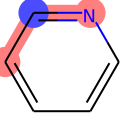

In [14]:
depictBit(1866,pyr,molSize=(125,125))

The other two are easy to envision: bit 1088 is all C, and bit 1603 has the N in the middle.

The radius 2 bits each have 5 atoms, here are a couple of them:

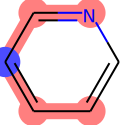

In [15]:
depictBit(1155,pyr,molSize=(125,125))

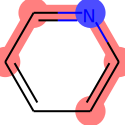

In [16]:
depictBit(383,pyr,molSize=(125,125))

The other two have the N in the second position (bit 437) or are pure C (bit 389)

That's pretty much it for this case.